---
---

<h1><center><ins>Exercise Sheet 11</ins></center></h1>
<h2><center>Numerical Methods <br><br>

---
---

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.io import fits


ModuleNotFoundError: No module named 'astropy'


## Exercise 1 — Periods in a Variable Star Light Curve & Aliasing

Stars typically exhibit differential rotation (because they are not solid), meaning that their rotational velocity changes as a function of latitude (i.e. rotation around the equator is faster than around the poles typically). 
One way to measure this differential rotation is by tracking darkspots on the surface of the star. The darkspots are areas, where the temperature of the star's surface is locally lower, i.e. the flux output will be lower as well.
Due to the rotation the total flux of the star will be temporarly dimmed, when the darkspot rotates into our line-of-sight. By recording the temporal change of the flux of star is called a Light Curve and we can estimate the stars's rotational velocity from it by assuming Keplerian rotation. (see e.g. https://hoys.space/lightcurve-of-the-week-358/ for an animation).
If there are multiple darkspots at different latitudes present on the star's surface, the recodered Light Curve will be a superposition of multiple sinusoids with different periods. 
Below you find a synthetic *Kepler-like* light curve of a spotted, differentially rotating star. The flux is the sum of three sinusoids plus some noise. The light curve is plotted below.

**A** Compute the one-sided power spectral density (PSD) using a FFT (you can use the build-in functions for FFT from numpy, but code your own function for the PSD) and find the three dominant rotations periods. Use the *find_peaks* function from *scipy.signal*. 
Plot the PSD and the peaks you found. What are the periods you found compared to the true ones?

**B** Compute the Nyquist frequency for the sampling, and **discuss** why this is important.

**C** Repeat **A** by assuming that you recorded the Light Curve only every $m$-th time. Use 8, 16 and 64 for m. What is happening to the PSD and the recovered periods?


B

Why is this important for cross-correlation redshift measurements?
- If the spectrum is undersampled (less than 2 pixels per resolution element), the cross-correlation peak’s shape can be distorted, and the measured shift can be ambiguous (aliasing), giving wrong redshift.
- The precision of the cross-correlation peak location depends on sampling the line profile adequately. With Nyquist sampling (~2 pixels per resolution element), we can interpolate the peak accurately.
- For detecting small velocity shifts (e.g., exoplanet radial velocities ~1 m/s), we need sampling fine enough so that the pixel scale is smaller than the expected shift. If the pixel scale in velocity is 1 km/s, you cannot reliably detect a 0.1 km/s shift without well-sampled lines.
- We use FFT for cross-correlation. If the spectrum is undersampled, high-frequency spectral features fold into lower frequencies (aliasing), corrupting the correlation.

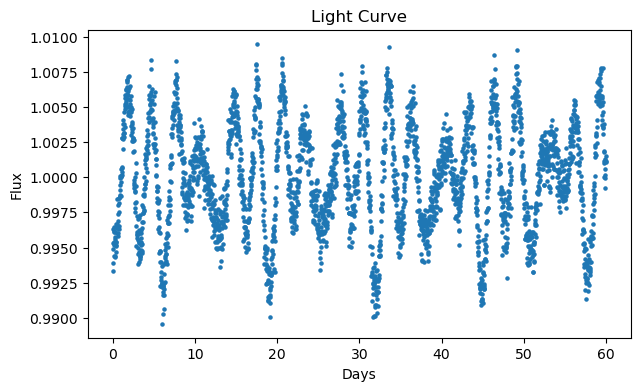

In [2]:

# --- Synthetic light curve ---
rng = np.random.default_rng(42)
# True periods (days)
P_true = np.array([3.2, 2.6, 6.5])
A_true = np.array([0.004, 0.0025, 0.0018])
phi_true = rng.uniform(0, 2*np.pi, size=3)

# Cadence and time base
dt = 30.0 / 60.0 / 24.0  # 30 minutes in days
T = 60.0                 # total baseline in days
t = np.arange(0, T, dt)

# Red-ish noise via filtering white noise
wn = rng.normal(0, 0.001, size=t.size)
# Simple 1D smoothing kernel for colored noise
kernel = np.exp(-0.5*((np.arange(-10,11))/4.0)**2)
kernel /= kernel.sum()
red_noise = np.convolve(wn, kernel, mode='same')

# Signal
signal = np.zeros_like(t)
for A, P, phi in zip(A_true, P_true, phi_true):
    signal += A * np.sin(2*np.pi*t/P + phi)

flux = 1.0 + signal + red_noise + wn

# --- Plot PSD ---
plt.figure(figsize=(7,4))
plt.scatter(t, flux, s=5)  # skip DC on log scale
plt.xlabel("Days")
plt.ylabel("Flux")
plt.title("Light Curve")
plt.show()


--- m = 1 (full cadence) ---
Cadence dt = 0.02083 days
Nyquist frequency = 24.000 day^-1
Recovered periods (days):
  2.609
  3.158
  6.667


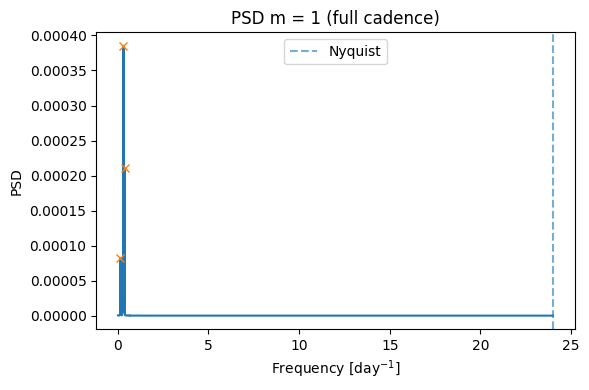


--- m = 8 ---
Cadence dt = 0.16667 days
Nyquist frequency = 3.000 day^-1
Recovered periods (days):
  2.609
  3.158
  6.667


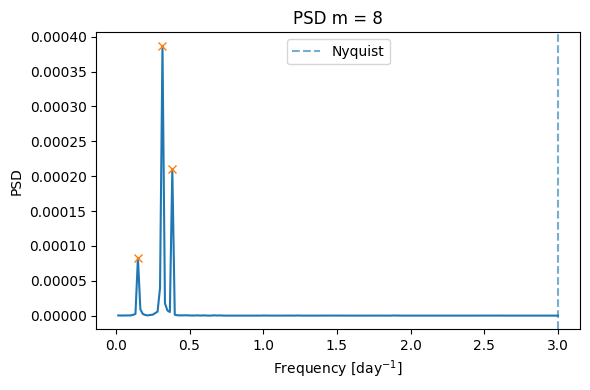


--- m = 16 ---
Cadence dt = 0.33333 days
Nyquist frequency = 1.500 day^-1
Recovered periods (days):
  2.609
  3.158
  6.667


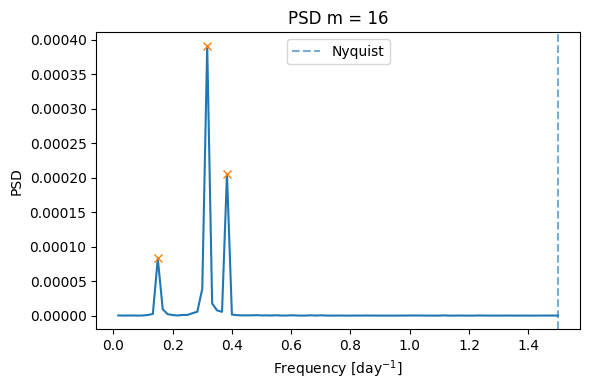


--- m = 64 ---
Cadence dt = 1.33333 days
Nyquist frequency = 0.375 day^-1
Recovered periods (days):
  3.158
  6.667


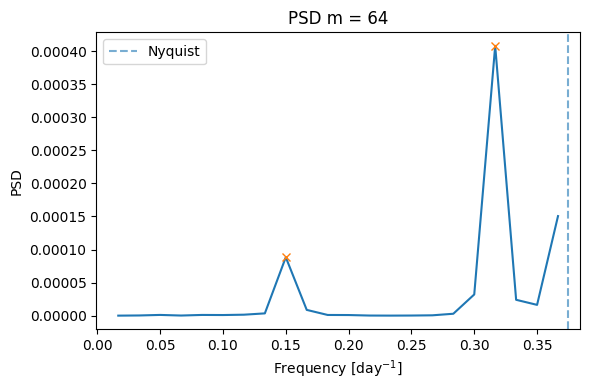

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


# 1. Synthetic light curve
rng = np.random.default_rng(42)

# True periods (days)
P_true = np.array([3.2, 2.6, 6.5])
A_true = np.array([0.004, 0.0025, 0.0018])
phi_true = rng.uniform(0, 2*np.pi, size=3)

# Time base
dt = 30.0 / 60.0 / 24.0   # 30 minutes in days
T = 60.0                 # total baseline in days
t = np.arange(0, T, dt)

# Red noise
wn = rng.normal(0, 0.001, size=t.size)
kernel = np.exp(-0.5 * (np.arange(-10, 11) / 4.0) ** 2)
kernel /= kernel.sum()
red_noise = np.convolve(wn, kernel, mode="same")

# Signal
signal = np.zeros_like(t)
for A, P, phi in zip(A_true, P_true, phi_true):
    signal += A * np.sin(2 * np.pi * t / P + phi)

flux = 1.0 + signal + red_noise


# 2. PSD function (one-sided)
def compute_psd(time, flux):
    dt = time[1] - time[0]
    N = len(time)

    flux_detrended = flux - np.mean(flux)
    fft = np.fft.rfft(flux_detrended)
    psd = (2.0 * dt / N) * np.abs(fft) ** 2
    freqs = np.fft.rfftfreq(N, dt)

    return freqs, psd


# 3. Analysis function
def analyze(time, flux, label=""):
    freqs, psd = compute_psd(time, flux)

    # Ignore DC component
    freqs = freqs[1:]
    psd = psd[1:]

    peaks, _ = find_peaks(psd, height=np.max(psd) * 0.1)
    peak_freqs = freqs[peaks]
    peak_periods = 1.0 / peak_freqs

    dt = time[1] - time[0]
    f_nyq = 1.0 / (2.0 * dt)

    print(f"\n--- {label} ---")
    print(f"Cadence dt = {dt:.5f} days")
    print(f"Nyquist frequency = {f_nyq:.3f} day^-1")
    print("Recovered periods (days):")
    for p in np.sort(peak_periods):
        print(f"  {p:.3f}")

    # Plot PSD
    plt.figure(figsize=(6, 4))
    plt.plot(freqs, psd)
    plt.plot(freqs[peaks], psd[peaks], "x")
    plt.axvline(f_nyq, ls="--", alpha=0.6, label="Nyquist")
    plt.xlabel("Frequency [day$^{-1}$]")
    plt.ylabel("PSD")
    plt.title(f"PSD {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 4. Full cadence
analyze(t, flux, label="m = 1 (full cadence)")


# 5. Downsampling experiments
for m in [8, 16, 64]:
    analyze(t[::m], flux[::m], label=f"m = {m}")



## Exercise 2 — Radial Velocity from FFT Cross-Correlation of Spectra

Below you see a real spectrum of the elliptical Galaxy NGC3522 taken from the SDSS survey (https://www.sdss.org/). This galaxy has an old stellar population and thus you see deep absorption lines coming from low-mass stars present in the galaxy.

**(A)** Ask your favourite AI to give you the wavelengths in air of the following lines: Ca H & K (H & K comes from the identification that Frauenhofer used when he studied the spectrum of the sun: https://en.wikipedia.org/wiki/Fraunhofer_lines), NaD (sodium doublet) and CaT (calcium triplet). Overplot the wavelength of those lines in the plot of the spectrum of NGC3522. Which formula now can give you very simply the redshift the galaxy?

One popular and perhaps a bit more sphosticated way to measure the redshift (or line-of-sight velocity) of a galaxy is to cross-correlate its spectrum with a template, or model spectrum, which does not contain any noise and where the absorption lines are at their known rest-frame wavelengths.

**(B)** Explain first very simply what cross-correlation is, and how we can measure the redshift from this. Explain also what this has to do with the Fourier Transform.

**(C)** Before you can cross-correlate the observed and modelled spectrum you need to convert the spacing between each recorded wavelength in your spectrum from linear to logarithmic. That means instead of $\lambda_{i+1}-\lambda_i=const.$, you need $\ln\lambda_{i+1}-\ln\lambda_i=const.$. Can you explain why that is? You can ask again your favourite AI if you wish (but please make sure you understand the answer ;). In the code below, you can see that the observed SDSS spectrum is already logarithmically re-binned and for the model spectrum, I am using the function *log_rebin* to convert the wavelength sampling from linear to logarithmic. Hence, there is no further action needed from your side for the next exercise.

**(C)** Implement your own cross correlation function by using build-in FFT methods. Plot the computed cross correlation function versus the lag in km/s. (**Hint**: the pixel spacing in $\AA$ per pixel of both the SDSS and model spectrum are constant in $\ln\lambda$, and the pixel spacing in km/s is stored in the variable *velscale*). Find the redshift you calculate from your cross-correlated signal (**Hint**: the redshift is now: np.exp(**[your solution in km/s]**/c)-1). How does your calculated redshift compare to the one provided by SDSS (**Hint**: it is stored in the variable *redshift_0*) ? For the template spectrum you can use the one provided in the file *Mbi0.30Zp0.40T13.5000_iTp0.00_baseFe.fits*. Below you will find some code to handle the template, which you just need to run.


B

It’s a way of measuring how similar two signals are, as you slide one past the other in time (or in space).
When they’re most similar, the cross-correlation has a peak.
The position of that peak tells you how much you had to shift one signal to match the other.

1. Take spectrum of star/galaxy → Get a pattern of lines (signal 1).

2.Compare with a lab reference spectrum (known rest wavelengths) → This is signal 2, with no shift.

3.Cross-correlate the observed spectrum with the reference spectrum:
Slide the reference spectrum in wavelength (like sliding in time for audio).
When lines match best, that shift in wavelength = redshift (or blueshift).

What does Fourier Transform have to do with this?
Cross-correlation computed directly by shifting and multiplying at each point is slow for large datasets.
There’s a mathematical relationship (the cross-correlation theorem) that says:
Cross-correlation(f,g)=Inverse Fourier Transform [ F(ω)⋅G∗(ω) ]
where FF is the Fourier Transform of the first signal, G∗G∗ is the complex conjugate of the Fourier Transform of the second signal

C

Cross-correlation works best when the signal we are trying to match is just a translation (same shape, shifted as a whole) in the independent variable of the data grid.
In linear λ, lines shift by different pixel amounts → distortion relative to template.
In ln⁡λ, lines shift by the same pixel amount for all lines → whole template matches just by sliding.

So: We convert to logarithmic wavelength → redshift is a constant pixel offset → cross-correlation peak is sharp and unambiguous.

In [ ]:
# these function convert the wavelengths of the SDSS spectrum (which are measured in vaccum) to wavelength of the model spectrum (which are given in air)
def _wave_convert(lam):
    """
    Convert between vacuum and air wavelengths using
    equation (1) of Ciddor 1996, Applied Optics 35, 1566
        http://doi.org/10.1364/AO.35.001566

    :param lam - Wavelength in Angstroms
    :return: conversion factor

    """
    lam = np.asarray(lam)
    sigma2 = (1e4/lam)**2
    fact = 1 + 5.792105e-2/(238.0185 - sigma2) + 1.67917e-3/(57.362 - sigma2)

    return fact

###############################################################################


def vac_to_air(lam_vac):
    """
    Convert vacuum to air wavelengths

    :param lam_vac - Wavelength in Angstroms
    :return: lam_air - Wavelength in Angstroms

    """
    return lam_vac/_wave_convert(lam_vac)

### This opens the SDSS spectrum of NGC 3522 (important thing here is that the variable *lam_gal* are the stored wavelengths and *galaxy* the flux recorded at every wavelength)
#### you can add part **A** in the code below

Text(0.5, 1.0, 'Spectrum of Galaxy NGC 3522')

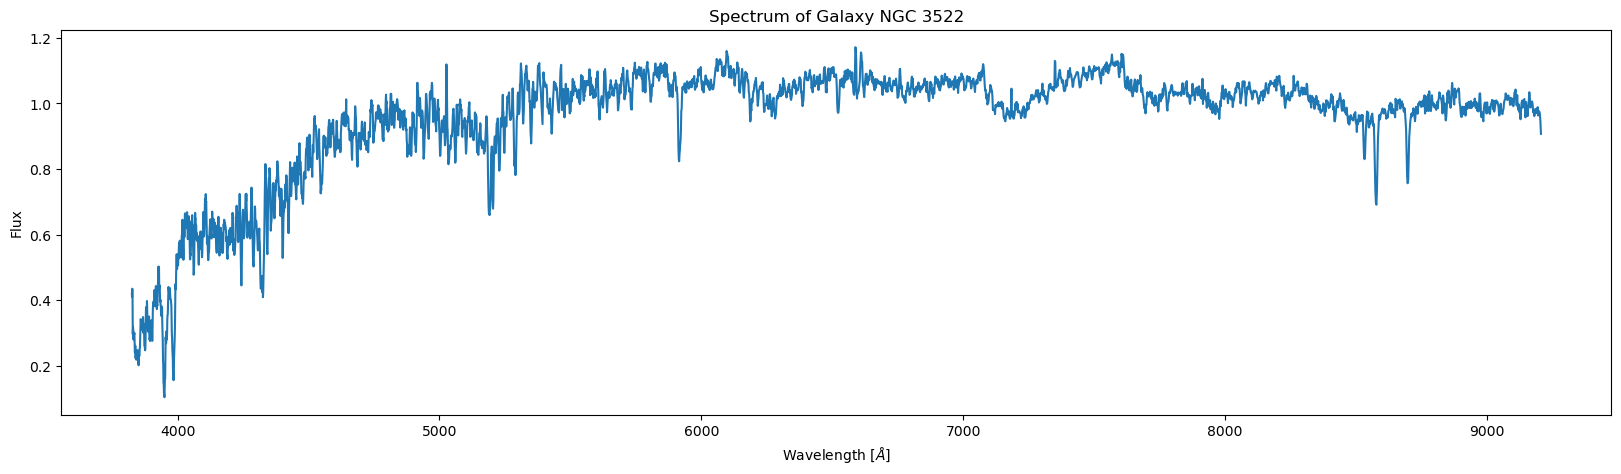

In [47]:
filename = 'NGC3522_SDSS_DR18.fits'
hdu = fits.open(filename)
t = hdu['COADD'].data
redshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)
lam_gal = vac_to_air(lam_gal)

c = 299792.458  # speed of light in km/s
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

plt.figure(figsize=(20,5))
plt.plot(lam_gal, galaxy)
plt.xlabel("Wavelength [$\AA$]")
plt.ylabel("Flux")
plt.title("Spectrum of Galaxy NGC 3522")




### This function converts a constant linear wavelength sampling to a constant logarithmic wavelength sampling (you do not need do understand the details of this)

In [6]:
def log_rebin(lam, spec, velscale=None, oversample=1, flux=False):
    lam, spec = np.asarray(lam, dtype=float), np.asarray(spec, dtype=float)
    assert np.all(np.diff(lam) > 0), '`lam` must be monotonically increasing'
    n = len(spec)
    assert lam.size in [2, n], "`lam` must be either a 2-elements range or a vector with the length of `spec`"

    if lam.size == 2:
        dlam = np.diff(lam)/(n - 1)             # Assume constant dlam
        lim = lam + [-0.5, 0.5]*dlam
        borders = np.linspace(*lim, n + 1)
    else:
        lim = 1.5*lam[[0, -1]] - 0.5*lam[[1, -2]]
        borders = np.hstack([lim[0], (lam[1:] + lam[:-1])/2, lim[1]])
        dlam = np.diff(borders)

    ln_lim = np.log(lim)
    c = 299792.458                          # Speed of light in km/s

    if velscale is None:
        m = int(n*oversample)               # Number of output elements
        velscale = c*np.diff(ln_lim)/m      # Only for output (eq. 8 of Cappellari 2017, MNRAS)
        velscale = velscale.item()          # Make velscale a scalar
    else:
        ln_scale = velscale/c
        m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels

    newBorders = np.exp(ln_lim[0] + velscale/c*np.arange(m + 1))

    if lam.size == 2:
        k = ((newBorders - lim[0])/dlam).clip(0, n-1).astype(int)
    else:
        k = (np.searchsorted(borders, newBorders) - 1).clip(0, n-1)

    specNew = np.add.reduceat((spec.T*dlam).T, k)[:-1]    # Do analytic integral of step function
    specNew.T[...] *= np.diff(k) > 0                      # fix for design flaw of reduceat()
    specNew.T[...] += np.diff(((newBorders - borders[k]))*spec[k].T)    # Add to 1st dimension

    if not flux:
        specNew.T[...] /= np.diff(newBorders)   # Divide 1st dimension

    # Output np.log(wavelength): natural log of geometric mean
    ln_lam = 0.5*np.log(newBorders[1:]*newBorders[:-1])

    return specNew, ln_lam, velscale

### This opens and prepares the **model** spectrum (important thing here is that the variable *lam_gal* are the stored wavelengths and *model* the flux recorded at every wavelength)

/var/folders/p1/qjv7_q354yzftsnt8bl2n2m40000gq/T/ipykernel_30451/1045276570.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels


Text(0.5, 1.0, 'Model Spectrum of an old, metal-rich stellar population')

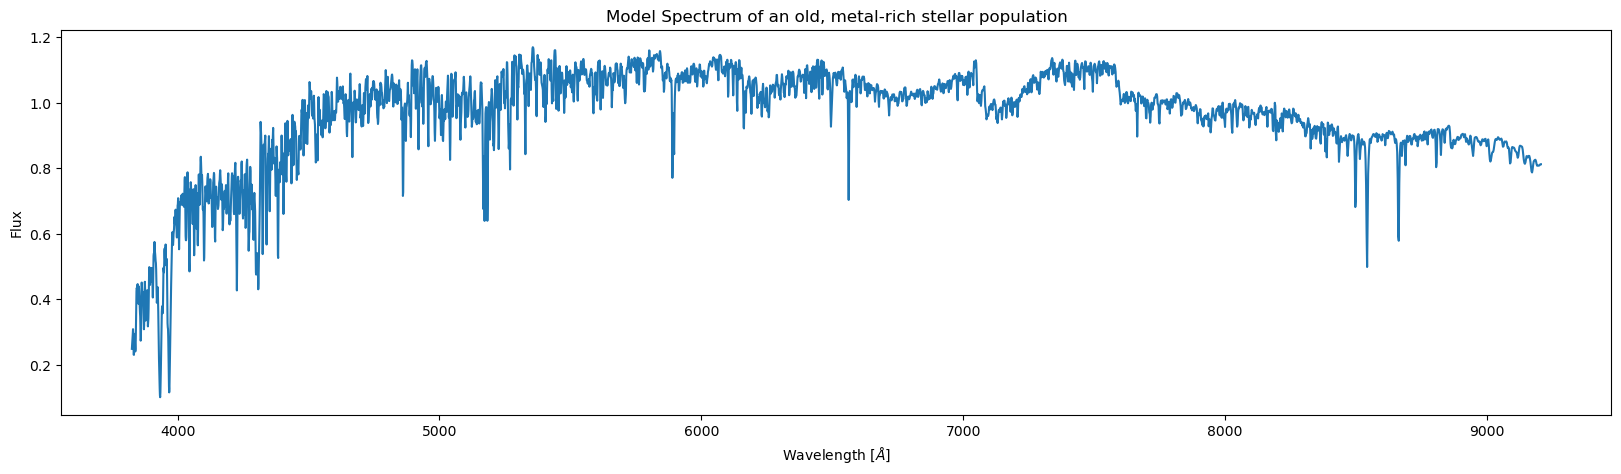

In [48]:
hdu=fits.open('Ech1.30Zm0.40T14.1254_iPp0.00_baseFe.fits')
model=hdu[0].data
wave, fwhm_a = np.loadtxt("emiles_spectral_resolution.dat" ,
                usecols=(0, 1),
                unpack=True,
            )
wave_mask = (wave < lam_gal[-1]) & (wave > lam_gal[0])
wave=wave[wave_mask]
model=model[wave_mask]
model/=np.nanmedian(model)
model, ln_lam_model, _ =log_rebin(np.array([lam_gal[0],lam_gal[-1]]), model, velscale)
wave = np.exp(ln_lam_model)
model=np.interp(lam_gal,wave,model) ###final flux of your modelled spectrum, use this for cross-correlation

plt.figure(figsize=(20,5))
plt.plot(lam_gal, model)
plt.xlabel("Wavelength [$\AA$]")
plt.ylabel("Flux")
plt.title("Model Spectrum of an old, metal-rich stellar population")

<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:122: SyntaxWarning: invalid escape sequence '\A'
<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:122: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_5404/2631695835.py:56: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Wavelength [$\AA$]")
/tmp/ipykernel_5404/2631695835.py:122: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Wavelength [$\AA$]")
/tmp/ipykernel_5404/2631695835.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels


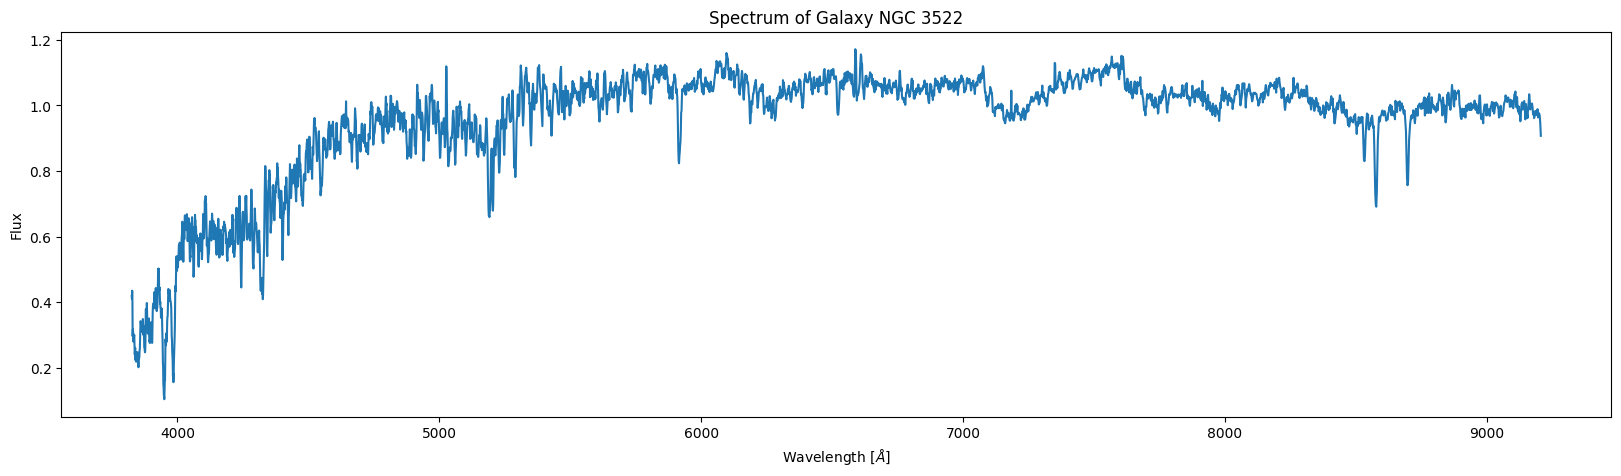

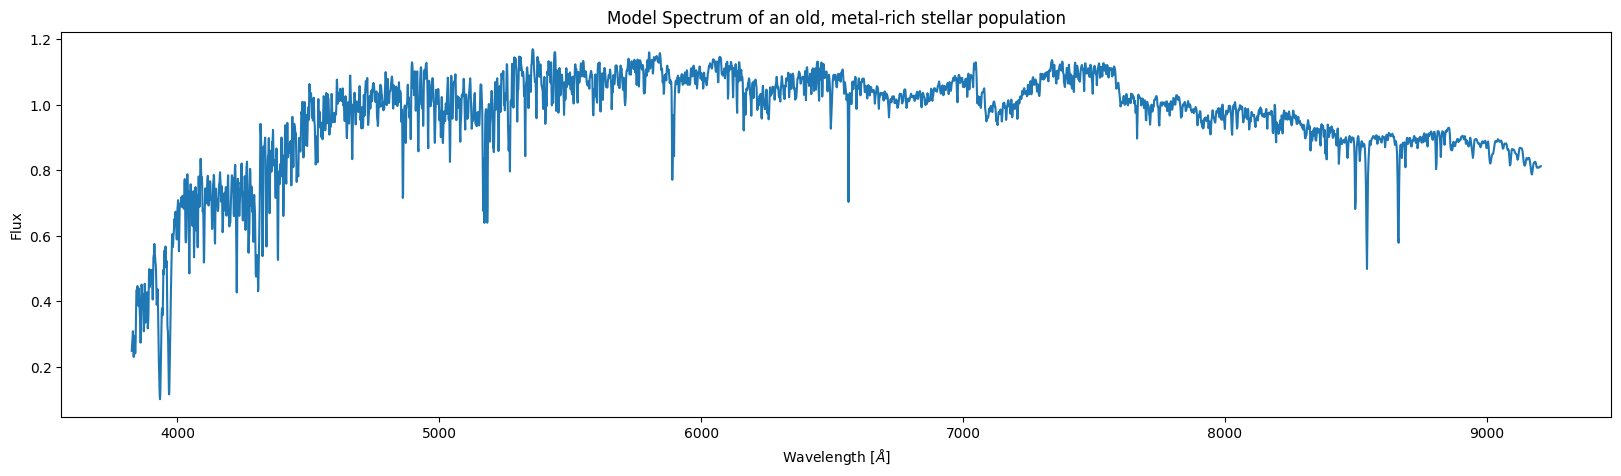

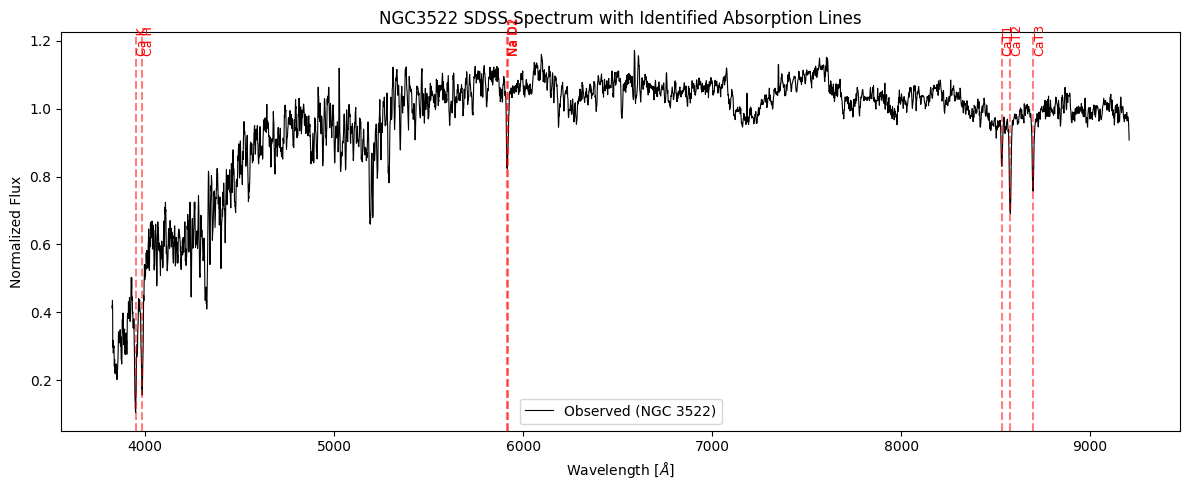

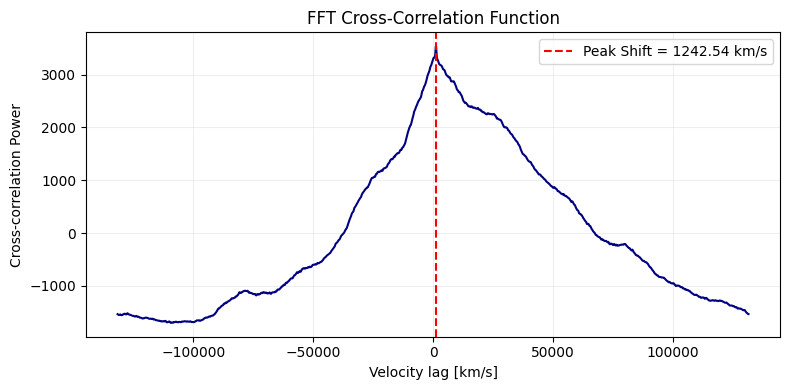


     RADIAL VELOCITY & REDSHIFT RESULTS
Velocity Shift (v)    : 1242.54 km/s
Derived Redshift (z)  : 0.004153
SDSS Header Redshift  : 0.004018
Difference (dz)       : 1.35e-04


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.fft import fft, ifft, fftshift

# these function convert the wavelengths of the SDSS spectrum (which are measured in vaccum) to wavelength of the model spectrum (which are given in air)
def _wave_convert(lam):
    """
    Convert between vacuum and air wavelengths using
    equation (1) of Ciddor 1996, Applied Optics 35, 1566
        http://doi.org/10.1364/AO.35.001566

    :param lam - Wavelength in Angstroms
    :return: conversion factor

    """
    lam = np.asarray(lam)
    sigma2 = (1e4/lam)**2
    fact = 1 + 5.792105e-2/(238.0185 - sigma2) + 1.67917e-3/(57.362 - sigma2)

    return fact

###############################################################################


def vac_to_air(lam_vac):
    """
    Convert vacuum to air wavelengths

    :param lam_vac - Wavelength in Angstroms
    :return: lam_air - Wavelength in Angstroms

    """
    return lam_vac/_wave_convert(lam_vac)


filename = 'NGC3522_SDSS_DR18.fits'
hdu = fits.open(filename)
t = hdu['COADD'].data
redshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)
lam_gal = vac_to_air(lam_gal)

c = 299792.458  # speed of light in km/s
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

plt.figure(figsize=(20,5))
plt.plot(lam_gal, galaxy)
plt.xlabel("Wavelength [$\AA$]")
plt.ylabel("Flux")
plt.title("Spectrum of Galaxy NGC 3522")

def log_rebin(lam, spec, velscale=None, oversample=1, flux=False):
    lam, spec = np.asarray(lam, dtype=float), np.asarray(spec, dtype=float)
    assert np.all(np.diff(lam) > 0), '`lam` must be monotonically increasing'
    n = len(spec)
    assert lam.size in [2, n], "`lam` must be either a 2-elements range or a vector with the length of `spec`"

    if lam.size == 2:
        dlam = np.diff(lam)/(n - 1)             # Assume constant dlam
        lim = lam + [-0.5, 0.5]*dlam
        borders = np.linspace(*lim, n + 1)
    else:
        lim = 1.5*lam[[0, -1]] - 0.5*lam[[1, -2]]
        borders = np.hstack([lim[0], (lam[1:] + lam[:-1])/2, lim[1]])
        dlam = np.diff(borders)

    ln_lim = np.log(lim)
    c = 299792.458                          # Speed of light in km/s

    if velscale is None:
        m = int(n*oversample)               # Number of output elements
        velscale = c*np.diff(ln_lim)/m      # Only for output (eq. 8 of Cappellari 2017, MNRAS)
        velscale = velscale.item()          # Make velscale a scalar
    else:
        ln_scale = velscale/c
        m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels

    newBorders = np.exp(ln_lim[0] + velscale/c*np.arange(m + 1))

    if lam.size == 2:
        k = ((newBorders - lim[0])/dlam).clip(0, n-1).astype(int)
    else:
        k = (np.searchsorted(borders, newBorders) - 1).clip(0, n-1)

    specNew = np.add.reduceat((spec.T*dlam).T, k)[:-1]    # Do analytic integral of step function
    specNew.T[...] *= np.diff(k) > 0                      # fix for design flaw of reduceat()
    specNew.T[...] += np.diff(((newBorders - borders[k]))*spec[k].T)    # Add to 1st dimension

    if not flux:
        specNew.T[...] /= np.diff(newBorders)   # Divide 1st dimension

    # Output np.log(wavelength): natural log of geometric mean
    ln_lam = 0.5*np.log(newBorders[1:]*newBorders[:-1])

    return specNew, ln_lam, velscale


hdu=fits.open('Ech1.30Zm0.40T14.1254_iPp0.00_baseFe.fits')
model=hdu[0].data
wave, fwhm_a = np.loadtxt("emiles_spectral_resolution.dat" ,
                usecols=(0, 1),
                unpack=True,
            )
wave_mask = (wave < lam_gal[-1]) & (wave > lam_gal[0])
wave=wave[wave_mask]
model=model[wave_mask]
model/=np.nanmedian(model)
model, ln_lam_model, _ =log_rebin(np.array([lam_gal[0],lam_gal[-1]]), model, velscale)
wave = np.exp(ln_lam_model)
model=np.interp(lam_gal,wave,model) ###final flux of your modelled spectrum, use this for cross-correlation

plt.figure(figsize=(20,5))
plt.plot(lam_gal, model)
plt.xlabel("Wavelength [$\AA$]")
plt.ylabel("Flux")
plt.title("Model Spectrum of an old, metal-rich stellar population")


# (A) Rest-frame absorption lines (air wavelengths, Å)


lines = {
    "Ca H": 3968.47,
    "Ca K": 3933.66,
    "Na D1": 5895.92,
    "Na D2": 5889.95,
    "CaT1": 8498.02,
    "CaT2": 8542.09,
    "CaT3": 8662.14
}

# Use variables from the first block
flux_obs = galaxy
flux_tpl = model
lam = lam_gal


# Plot spectrum with absorption lines (A)


plt.figure(figsize=(12, 5))
plt.plot(lam, flux_obs, color="black", lw=0.8, label="Observed (NGC 3522)")

# Fixing the SyntaxWarning by using r"..." for LaTeX
for name, l0 in lines.items():
    line_pos = l0 * (1 + redshift_0)
    if lam[0] < line_pos < lam[-1]:
        plt.axvline(line_pos, ls="--", color="red", alpha=0.5)
        plt.text(line_pos, plt.ylim()[1]*0.95, name, rotation=90, color="red", fontsize=9)

plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel("Normalized Flux")
plt.title("NGC3522 SDSS Spectrum with Identified Absorption Lines")
plt.legend()
plt.tight_layout()
plt.show()


# (B) Cross-correlation via FFT

def cross_correlation_fft(f, g):
    # Standardize signals
    f_norm = (f - np.nanmean(f)) / np.nanstd(f)
    g_norm = (g - np.nanmean(g)) / np.nanstd(g)
    
    # Perform FFT cross-correlation
    # We use the same length as the input since they are already matched
    return fftshift(ifft(fft(f_norm) * np.conj(fft(g_norm))).real)

ccf = cross_correlation_fft(flux_obs, flux_tpl)


# Velocity axis (km/s)


n = len(ccf)
# Create lag axis centered at zero
lags = (np.arange(n) - n // 2) * velscale


# (C) Find velocity shift and redshift


# The peak of the CCF tells us the velocity offset
peak_idx = np.argmax(ccf)
v_peak = lags[peak_idx]
c_light = 299792.458 

# Redshift calculation from velocity shift
# z = exp(v/c) - 1 is the correct form for log-rebinned spectra
z_fft = np.exp(v_peak / c_light) - 1

# Plot cross-correlation function


plt.figure(figsize=(8, 4))
plt.plot(lags, ccf, color="navy")
plt.axvline(v_peak, color="red", ls="--", label=f"Peak Shift = {v_peak:.2f} km/s")
plt.xlabel("Velocity lag [km/s]")
plt.ylabel("Cross-correlation Power")
plt.title("FFT Cross-Correlation Function")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


# Results

print("\n" + "="*40)
print("     RADIAL VELOCITY & REDSHIFT RESULTS")
print("="*40)
print(f"Velocity Shift (v)    : {v_peak:.2f} km/s")
print(f"Derived Redshift (z)  : {z_fft:.6f}")
print(f"SDSS Header Redshift  : {redshift_0:.6f}")
print(f"Difference (dz)       : {abs(z_fft - redshift_0):.2e}")
print("="*40)


## Exercise 3 — The power of FFT in 2D image convolutions

In astronomy we are (de)convolving images all the time with, for example, the Point Spread Function (PSF). This would not be possible without the Fast Fourier Transform (FFT) and in this exercise we want to explore that a bit more.

**(A)** To get started write a simple function that returns you an image (2D array) of a simulated star field with infinitely sharp stars (i.e. Delta-function-like stars with no PSF/blurring effects). The function should take the size of the desired image as an argument (make it a square image for simplicity). The stars should be randomly distributed in the field-of-view with random magnitudes. Plot the resulting image for an image size of 128 pixels using *imshow* from *matpotlib*.

**(B)** Now we want to blurr out these image with the PSF (as we would observe them with a telescope). This processes is called *convolution* and the PSF would be our convolution *kernel*, which means that basically for each pixel in your simulated star field image, you apply a blurring, or spreading out of the flux of the stars across neighbouring pixels. The kernel describes in which way this spreading out is done. Write a function for the convolution kernel, i.e. the PSF. Assume that the PSF is Gaussian. Plot the resulting PSF assuming a kernel size of 21 pixels and a FWHM of 2.5 pixels.

**(C)** Doing convolution in image (or pixel) space is not very efficient. Luckly, doing a convolution in Fourier Space becomes easy, since the convolution reduces to a simple multiplication of the Fourer Transform of the image and the kernel. We then arrive back at the real blurred (PSF-convolved) image by calculating the inverse of the Fourier Transform. Implement now your **own algorithm** for FFT and its inverse. Convolve the image from **(A)** with the PSF from **(B)** and plot the new blurred image.

**HINT** Consider the following steps for **(C)**:

*1)* Implement the FFT algorithm for a 1D signal.

*2)* Write a function that calculates the inverse FFT. This function will use the forward FFT (think about the symmetries between discussed in the lecture as your signal only has a real part)

*3)* Calculating the 2D FFT is the same as first calculating 1D FFT along the rows and then along the columns of the image.

*4)* Before you can multiply the FFT of the image and the kernel you need to pad the PSF kernel with zeros to match the image size.

*5)* If you are spending more than 1hr on part **C** alone you may use your favourite AI to help you implement the code, but make sure you can explain/understand the steps that it is doing.

**(D)** Now we want to test the speed of your FFT convolution algorithm versus the **build-in** FFT convolution from *scipy.signal* called *fftconvolve* as well as the naive discrete convolution *convolve2d*. For this write a loop for varying image sizes. Each time double the number of pixels from **(A)**. Do this for times (or less if you have to wait for hours). For each loop time the three convolution functions using *time.time()* (build-in python package). Make a plot of computational time (log-scaled y-axis) vs. number of pixels in the image (x-axis) for all three functions. Who is the winner? How does this compare to the theoretical computational complexity of using FFT and the naive discrete convolution?

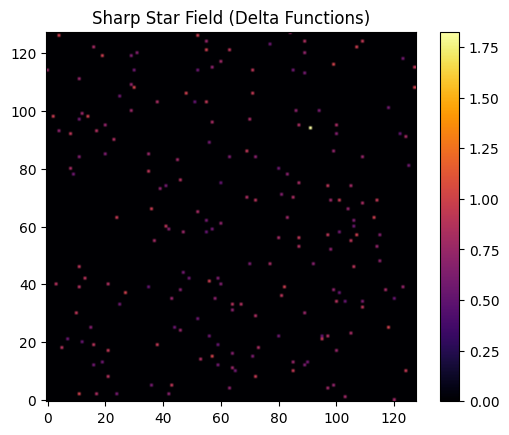

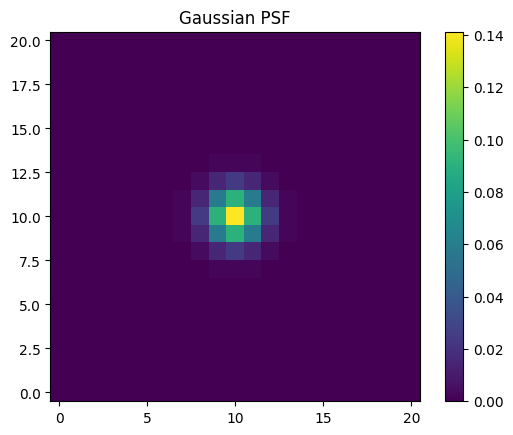

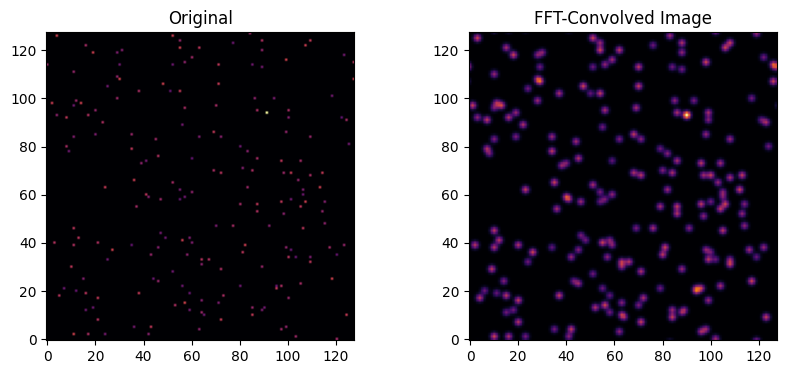

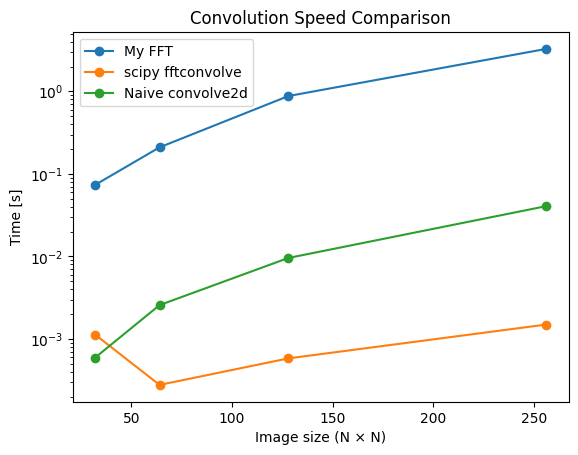

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, convolve2d
import time

#a
def star_field(size, n_stars=200, seed=42):
    rng = np.random.default_rng(seed)
    image = np.zeros((size, size))

    x = rng.integers(0, size, n_stars)
    y = rng.integers(0, size, n_stars)
    flux = rng.uniform(0.5, 1.0, n_stars)

    for xi, yi, fi in zip(x, y, flux):
        image[yi, xi] += fi

    return image


img = star_field(128)
plt.imshow(img, origin="lower", cmap="inferno")
plt.colorbar()
plt.title("Sharp Star Field (Delta Functions)")
plt.show()


#b
def gaussian_psf(size, fwhm):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    ax = np.arange(size) - size // 2
    xx, yy = np.meshgrid(ax, ax)

    psf = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    psf /= psf.sum()

    return psf


psf = gaussian_psf(21, fwhm=2.5)
plt.imshow(psf, origin="lower", cmap="viridis")
plt.colorbar()
plt.title("Gaussian PSF")
plt.show()

#c1
def fft1d(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]

    if N <= 1:
        return x

    if N % 2 != 0:
        raise ValueError("Size must be power of 2")

    even = fft1d(x[::2])
    odd = fft1d(x[1::2])

    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    return np.concatenate([even + factor[:N//2] * odd,
                            even + factor[N//2:] * odd])

#c2
def ifft1d(X):
    X = np.asarray(X, dtype=complex)
    N = X.shape[0]
    return np.conjugate(fft1d(np.conjugate(X))) / N

#c3
def fft2d(image):
    temp = np.array([fft1d(row) for row in image])
    return np.array([fft1d(col) for col in temp.T]).T


def ifft2d(freq):
    temp = np.array([ifft1d(row) for row in freq])
    return np.array([ifft1d(col) for col in temp.T]).T

#c4
def fft_convolve2d(image, kernel):
    ny, nx = image.shape

    # Pad PSF
    ky, kx = kernel.shape
    pad_kernel = np.zeros_like(image)
    pad_kernel[:ky, :kx] = kernel
    pad_kernel = np.roll(pad_kernel, -ky//2, axis=0)
    pad_kernel = np.roll(pad_kernel, -kx//2, axis=1)

    F_img = fft2d(image)
    F_psf = fft2d(pad_kernel)

    convolved = np.real(ifft2d(F_img * F_psf))
    return convolved

blurred = fft_convolve2d(img, psf)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, origin="lower", cmap="inferno")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(blurred, origin="lower", cmap="inferno")
plt.title("FFT-Convolved Image")
plt.show()


#d
def benchmark():
    sizes = [32, 64, 128, 256]
    t_myfft, t_scipy, t_naive = [], [], []

    for N in sizes:
        img = star_field(N, n_stars=N)
        psf = gaussian_psf(21, 2.5)

        # My FFT
        start = time.time()
        fft_convolve2d(img, psf)
        t_myfft.append(time.time() - start)

        # scipy FFT
        start = time.time()
        fftconvolve(img, psf, mode="same")
        t_scipy.append(time.time() - start)

        # Naive convolution
        start = time.time()
        convolve2d(img, psf, mode="same")
        t_naive.append(time.time() - start)

    plt.plot(sizes, t_myfft, "o-", label="My FFT")
    plt.plot(sizes, t_scipy, "o-", label="scipy fftconvolve")
    plt.plot(sizes, t_naive, "o-", label="Naive convolve2d")
    plt.yscale("log")
    plt.xlabel("Image size (N × N)")
    plt.ylabel("Time [s]")
    plt.legend()
    plt.title("Convolution Speed Comparison")
    plt.show()


benchmark()


